# Tarea 7 - Machine Learning

In [185]:
#Librerias y funciones
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_openml
import seaborn as sns
import os
from lxml import etree
from bs4 import BeautifulSoup
import re
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [139]:
def clean_sgm_file(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        sgm_content = f.read()
    sgm_content = re.sub(r'[\x00-\x1F\x7F]','', sgm_content)
    return sgm_content

In [ ]:
def parse_reuters_data(file_path):

    cleaned_sgm_content = clean_sgm_file(file_path)

    soup = BeautifulSoup(cleaned_sgm_content, 'html.parser')
    articles = []
    labels = []
    
    for reuters_item in soup.find_all('reuters'):

        text_tag = reuters_item.find('text')
        text = text_tag.text if text_tag else ''

        #Categoria
        topics_tag = reuters_item.find('topics')
        category_tag = topics_tag.find('d') if topics_tag else None
        category = category_tag.text if category_tag else 'Unknown'
        
        if text and category:
            articles.append(text.strip())
            labels.append(category.strip())

    return pd.DataFrame({'text': articles, 'category': labels})

## Ejercicio 1

Las maquinas de vector de soporte son un caso particular de los modelos discriminantes, ya que gran parte de su éxito se ha basado en la introducción del truco del kernel para extender sus capacidades básicas. Realiza una breve investigación sobre los diversos tipos de kernel que existen y cómo se realiza su implementación Python y la librería Scikit-Learn.

**Support Vector Machine**

Las máquinas de Vectores de Soporte, son una extensión de la idea del Clasificador de Vectores de Soporte, donde la idea es la clasificación. El objetivo principal es encontrar un hiperplano el cual separe de manera óptima las clases en el espacio de características, sin embargo, en algunas ocasiones se puede llegar a usar como regresión, métoodo de penalización, etc.

Las máquinas de vectores de soporte cuenta con 3 principales características:

- Márgenes máximos: El objetivo principal es encontrar el margen más amplio entre las clases, debido a que esto aumenta la capacidad de generalización del modelo.
- Clasificación binaria: Usualmente se utiliza para la clasificación binaria, aunque se puede llegar a usar para clasificación multiclase.
- Hiperplanos en espacios de alta dimensión

Tipos de kernel

El kernel es una función matemática que permite transformar los datos en un espacio de características de mayor dimensión sin necesidad de calcular explícitamente las coordenadas en ese espacio. Esto permite a SVM encontrar un hiperplano en un espacio no lineal.

- Kernel Lineal: Es el más sencillo y se suele utilizar cuando los datos están linealmente separados (i.e. se pueden separar mediante una línea o hiperplano en un espacio de características). La ventaja más clara es que cuando los datos son lineales, es bastante rápido, se suele representar de la siguiente manera:

$$K(x,y) = x^{T}y$$

- Kernel polinómico: Permite transformar los datos a un espacio de característicos de mayor dimensión usando un polinomio de grado $d$. Se utiliza cuando los datos no son linealmente separables, pero pueden ser separados mediante una curva.

$$K(x,y) = (x^{T}y + c)^{d}$$

Donde $c$ es un parámetro que controla el margen de la transformación y $d$ el grado del polinomio.

- Kernel RBF(Radial Basis Function): Es uno de los más utilizados y es especialmente útil cuando los datos no son lineales y están distribuidos de manera compleja. Utiliza una función gaussiana para transformar los datos en un espacio de características de alta dimensión.

$$K(x,y) = e^{-\gamma||x-y||^{2}}$$

Donde $\gamma$ es un parámetro que controla la influencia de cada punto. Si $\gamma$ es muy pequeño, la influencia de cada punto es grande. Si es muy grande, el modelo se ajustará a los datos de manera demasiado específica.

- Kernel Sigmoide: Este kernel está basado en la función sigmoide y se suele utilizar menos que el RBF. Es similar a la función de activación de una red neuronal. Es útil para problemas de clasificación no lineales, pero generalmente se usa menos que los otros kernels.

$$K(x,y) = tanh(\alpha x^{T}y+c)$$

Donde $\alpha$ y $c$ son parámetros que controlan la forma de la función

Implementación en Pyhon

Existe una sencilla forma de demostrar la gran utilidad de las SVM y es comparándola con un modelo de regresión logística, por ende, lo mostraré a continuación

In [33]:
#Primero importamos las librerías necesarias
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
import mglearn #Dataset para el análisis
import matplotlib.pyplot as plt

In [29]:
X,y = mglearn.datasets.make_forge() #Datos

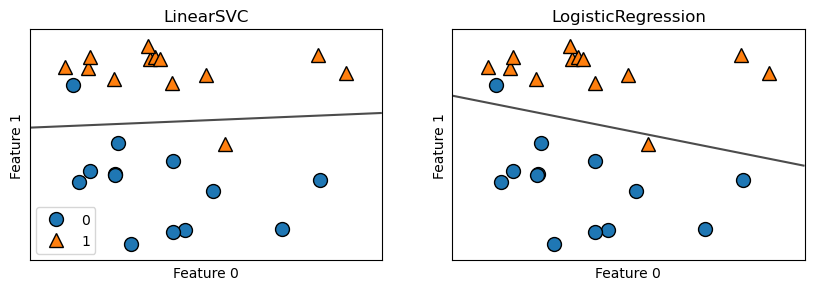

In [37]:
fig, axes = plt.subplots(1,2,figsize=(10,3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X,y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=.5, ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:,0], X[:,1], y, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')

axes[0].legend()

Como se alcanza a notar, ambos modelos son usualmente utilizados para la clasificación binaria y ambos presentan resultados bastante parecidos, claro, se puede abordar más para notar y aclarar más la diferencia entre ambos modelos, sin embargo, deja en claro qué tan bien clasifica el modelo de SVM

$Bibliografía$ 
- "The Elements of Statistical Learning: Data Mining, Inference, and Prediction" por Trevor Hastie, Robert Tibshirani y Jerome Friedman
- "Introduction to Machine Learning with Python" por Andreas C. Müller y Sarah Guido

## Ejercicio 2

Identifica una problemática del cual puedas obtener una cantidad considerable de muestras, y cuya solución requiera de un proceso de clasificación multinomial. Realiza:
- Elabora un programa de Python que utilice un modelo de máquina de vector de soporte con kernel para solucionar el problema
- Compara los resultados obtenidos modificando el tipo de kernel
- Evalúa la precisión de los modelos para cada caso

Utilizando un set de datos externos de la página de UC Irvine, utilizaremos el dataset correspondiente a Reuters-21578. El cual provee un set de datos correspondientes a categorización de tipos de libros. Primero cargaré el dataset y realizaré un análisis exploratorio

In [99]:
#d_path = 'C:/MIGUEL/Máster/Modulo2/Tarea 7/reuters_data/'

sgm_file = os.path.join(d_path, 'Tarea7_ML - reut2-000.sgm')

In [131]:
data = parse_reuters_data(sgm_file)

In [136]:
data.head(5)

,text,category
0,"BAHIA COCOA REVIEW SALVADOR, Feb 26 - Show...",cocoa
1,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT ...,Unknown
2,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN ...,Unknown
3,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER ...,Unknown
4,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESE...,grain


El set cuenta con un total de 1000 textos analizados

Como se puede observar, la información cuenta con 2 columnas, una de texto y otra de categoría de texto. En este set se provee directamente la categoría del texto en el mismo archivo, sin embargo, sería interesante realizar un análisis más profundo sobre el texto, con el fin de añadir más características al set de datos con el fin de mejorar el rendimiento del modelo. 

Ahora, realizaré un análisis exploratorio de los datos

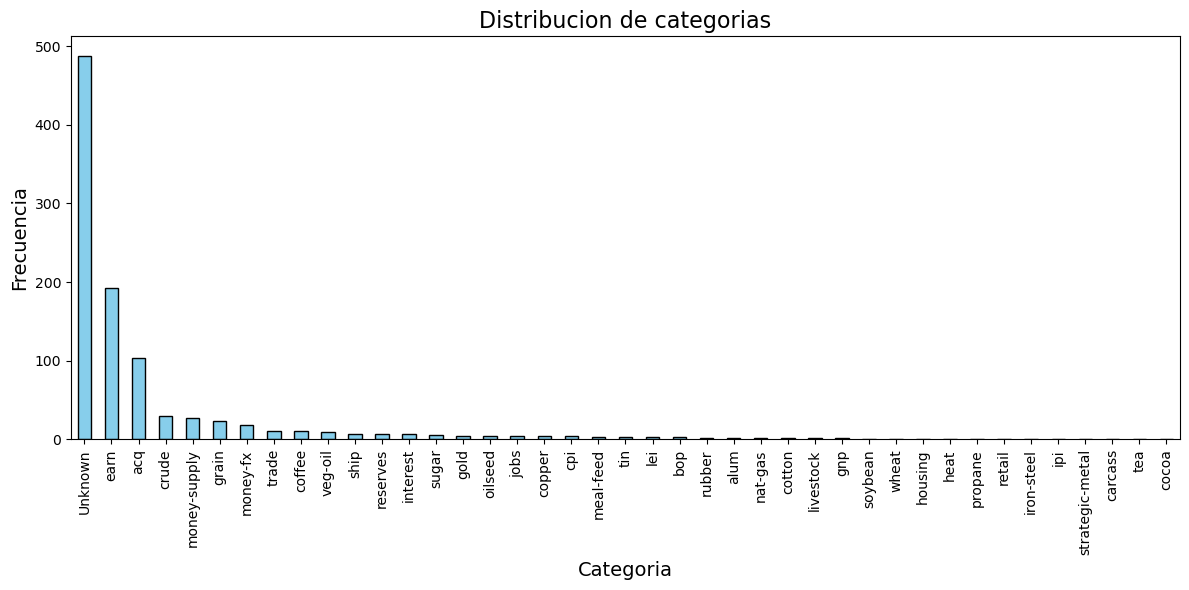

In [148]:
category_counts = data['category'].value_counts()

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribucion de categorias', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Como se puede notar, hay una gran cantidad de categorias desconocidas, seguido por la categoria de 'earn' (ahorro), 'acq' (cuestionarios). El set se basa en la premisa del texto con el fin de categorizar los textos previamente presentados.

Comenzando con el modelo

In [152]:
#Se procede a haver una vectorización de las variables con el fin de transfomarlas
vectorizer = TfidfVectorizer(stop_words = 'english', max_features=1000)

X = vectorizer.fit_transform(data['text'])
y = data['category']

In [158]:
#Asignamos un porcentaje al set de prueba de 20% y 80% al entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [160]:
print(X_train.shape)
print(X_test.shape)

(800, 1000)
(200, 1000)


In [187]:
model = SVC(kernel = 'linear') #Kernel Lineal
model.fit(X_train, y_train)

joblib.dump(model, r'Tarea7_ML - svm_linear.joblib')

y_pred = model.predict(X_test)

['C:\\MIGUEL\\Máster\\Modulo2\\Tarea 7\\svm_linear.joblib']

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report:
              precision    recall  f1-score   support

     Unknown       0.67      0.89      0.77        95
         acq       0.80      0.36      0.50        22
         bop       0.00      0.00      0.00         1
     carcass       0.00      0.00      0.00         1
      coffee       1.00      1.00      1.00         2
         cpi       0.00      0.00      0.00         1
       crude       1.00      0.67      0.80         6
        earn       0.81      0.88      0.84        40
       grain       0.33      0.50      0.40         2
    interest       0.00      0.00      0.00         3
        jobs       0.00      0.00      0.00         1
         lei       0.00      0.00      0.00         1
   meal-feed       0.00      0.00      0.00         1
    money-fx       1.00      0.40      0.57         5
money-supply       0.83      1.00      0.91         5
     nat-gas       0.00      0.00      0.00         1
     oilseed       0.00      0.00      0.00         2
    

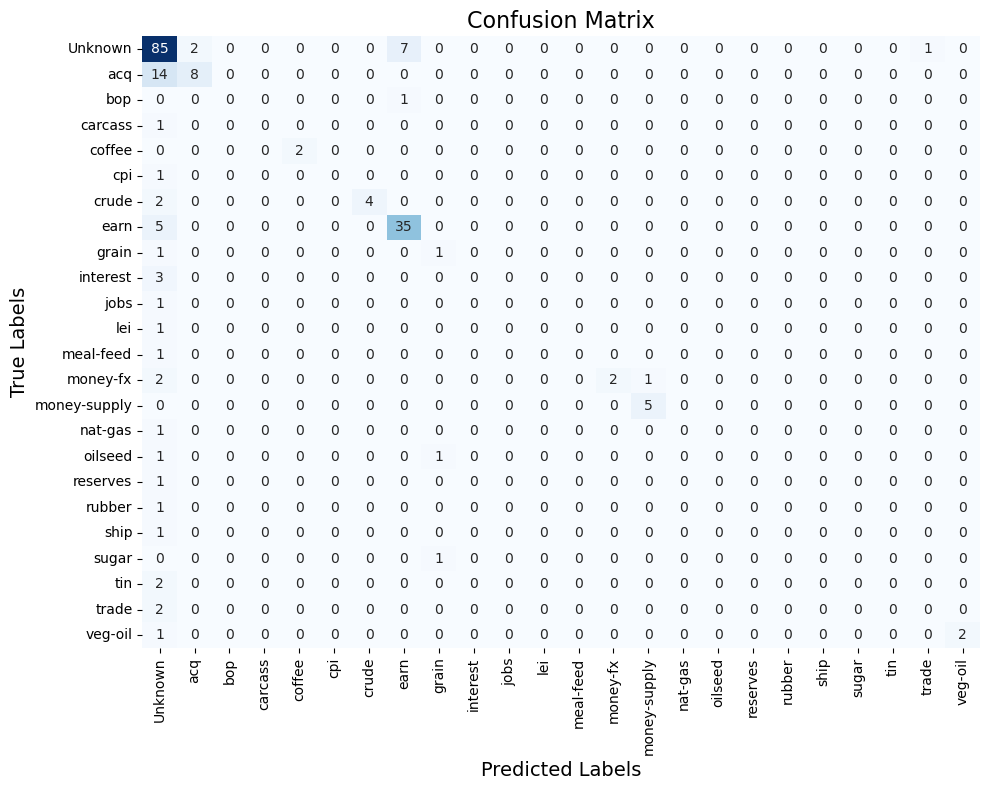

In [183]:
print(f'Classification report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

Comenzando con SVM con kernel *lineal*, obtenemos las siguientes conclusiones:
- El tipo de texto con más recurrencias, es decir, 'Unknown' presenta una baja precisión, sin embargo, una exactitud de 89%. Esto quiere decir que, a pesar que el modelo no tiene una alta precisión para reconocer los textos de tipo desconocido, suele tener una alta exactitud al momento de evaluar esa decisión.
- De igual manera, de todos los textos analizados, los mejores clasificados fueron los 'Unknown', apoyando el punto pasado, al igual que los textos predichos como 'earn'.
- El modelo en conclusión presenta una precisión baja, pero una alta exactitud

In [189]:
model = SVC(kernel = 'poly') #Kernel polinomial
model.fit(X_train, y_train)

joblib.dump(model, r'Tarea7_ML - svm_poly.joblib')

y_pred = model.predict(X_test)

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report:
              precision    recall  f1-score   support

     Unknown       0.56      0.95      0.71        95
         acq       1.00      0.14      0.24        22
         bop       0.00      0.00      0.00         1
     carcass       0.00      0.00      0.00         1
      coffee       1.00      1.00      1.00         2
         cpi       0.00      0.00      0.00         1
       crude       0.00      0.00      0.00         6
        earn       0.87      0.65      0.74        40
       grain       0.00      0.00      0.00         2
    interest       1.00      0.67      0.80         3
        jobs       0.00      0.00      0.00         1
         lei       0.00      0.00      0.00         1
   meal-feed       0.00      0.00      0.00         1
    money-fx       1.00      0.40      0.57         5
money-supply       0.00      0.00      0.00         5
     nat-gas       0.00      0.00      0.00         1
     oilseed       0.00      0.00      0.00         2
    

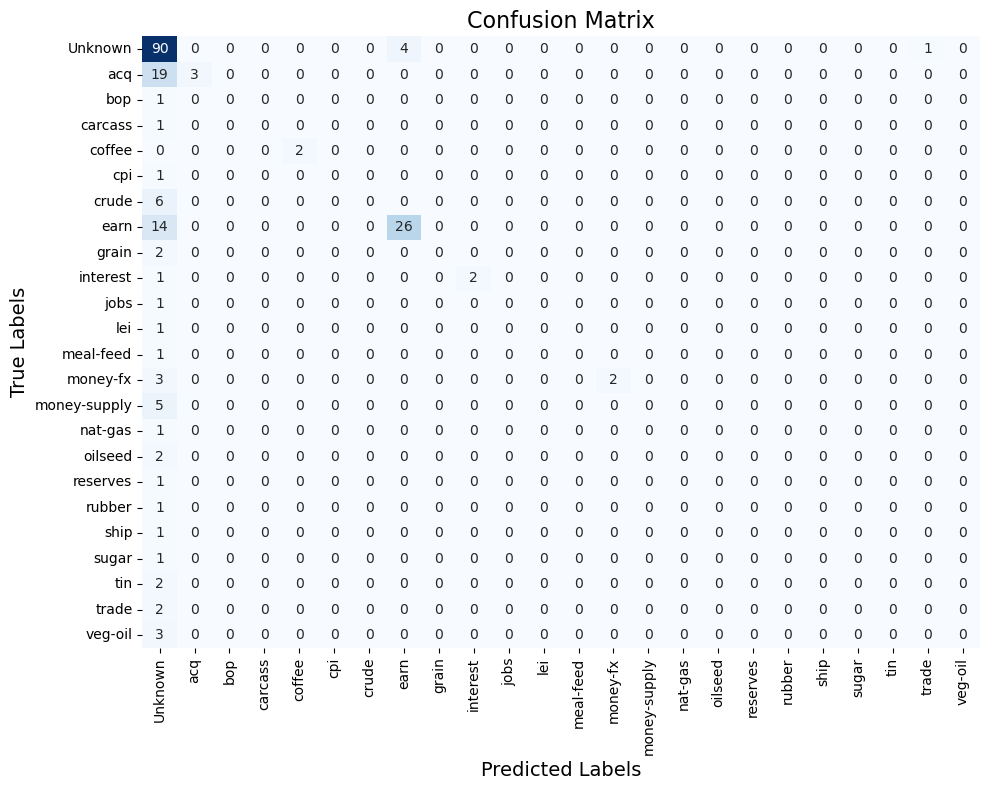

In [191]:
print(f'Classification report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

Por otro lado, el SVM utilizando un núcleo *polinomial*, presenta las siguientes conclusiones:
- Este modelo presenta una menor precisión al momento de clasificar los textos, sin embargo, un gran aumento en la exactitud del modelo.
- El aumento se ve reflejado en la precisión de clasificar como desconocido (unknown) los textos evaluados y un decremento en los textos 'earn'. Esto se puede deber a que los textos realmente no tienen asignados un tema.
- Se podría tener una mejora en el modelo, sin embargo, depende méramente de lo que el usuario busque, si una mayor precisión o exactitud.

In [193]:
model = SVC(kernel = 'rbf') #Kernel polinomial
model.fit(X_train, y_train)

joblib.dump(model, r'Tarea7_ML - svm_rbf.joblib')

y_pred = model.predict(X_test)

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report:
              precision    recall  f1-score   support

     Unknown       0.59      0.93      0.72        95
         acq       0.75      0.14      0.23        22
         bop       0.00      0.00      0.00         1
     carcass       0.00      0.00      0.00         1
      coffee       1.00      1.00      1.00         2
         cpi       0.00      0.00      0.00         1
       crude       1.00      0.67      0.80         6
        earn       0.84      0.78      0.81        40
       grain       0.00      0.00      0.00         2
    interest       0.00      0.00      0.00         3
        jobs       0.00      0.00      0.00         1
         lei       0.00      0.00      0.00         1
   meal-feed       0.00      0.00      0.00         1
    money-fx       1.00      0.40      0.57         5
money-supply       1.00      0.20      0.33         5
     nat-gas       0.00      0.00      0.00         1
     oilseed       0.00      0.00      0.00         2
    

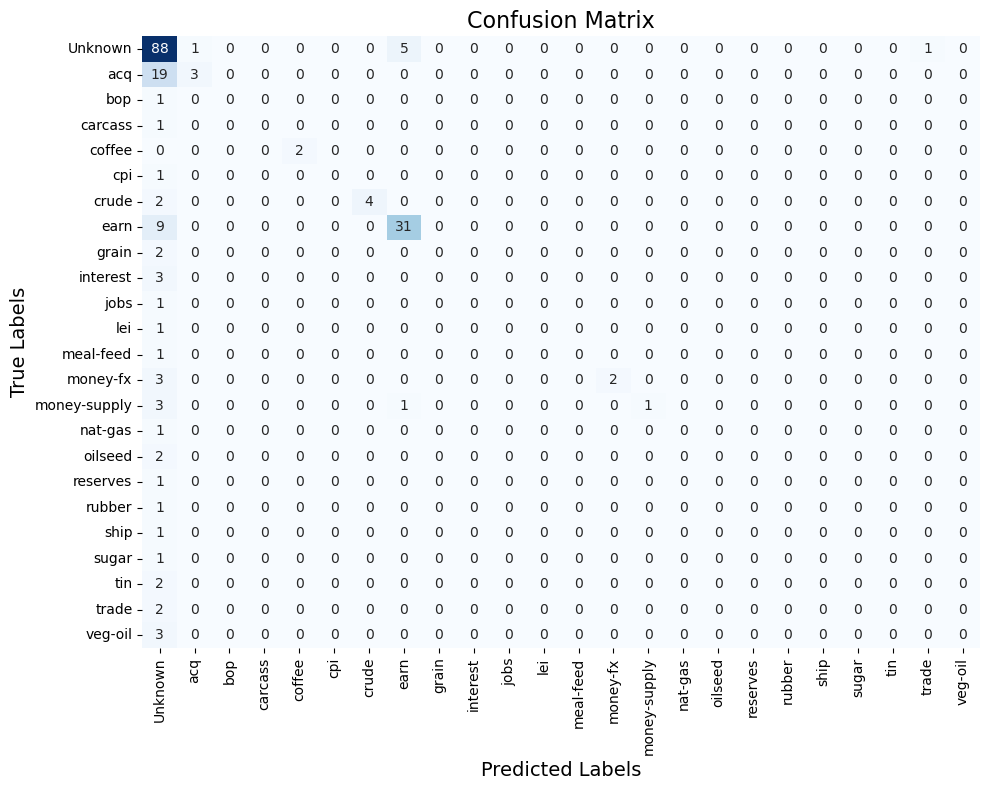

In [195]:
print(f'Classification report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

Por último, el modelo de SVM utilizando el kernel *rbf*, presenta un resultado similar al kernel polinomial. En general, se puede explicar o dar a entender que los datos tienen una distribución lineal y por ello el kernel lineal queda mejor para este modelo. Sin embargo, si tiene un ligero aumento en la exactitud con respecto al modelo utilizando el kernel lineal.

## Ejercicio 3

Investiga sobre los modelos generativos basados en el aprendizaje profundo y elabora un ensayo (mínimo 2 cuartillas), en donde se exprese el estado del arte en esta rama de la investigación, así como sus impresiones personales sobre la aplcación práctica de este tipo de modelos en los próximos años.

En caso de requerir mayor información, se adjunta un archivo pdf o se encuentra en la carpeta de ../reports/GenModels_DeepLearning.pdf